# Retina encoder


author: carlo paris; modified by laquitainesteeve@gmail.com

Execution time: 1 sec

tested on:  

- Apple M4 16GB RAM (no GPU required)
- Ubuntu 180 GB RAM

## Setup 


activate fisher_info_limits2

```python
python -m ipykernel install --user --name fisher_info_limits2 --display-name "fisher_info_limits2"
```

In [ ]:
# import packages
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle5 as pickle
from scipy.stats import spearmanr, wilcoxon

from matplotlib.gridspec import GridSpec as GS
import math
#import import_ipynb
#import ipynb.fs.full.ssiProjectModule as ssiMod

main_dir = '/home/steeve/steeve/idv/code/fisher-info-limits'
os.chdir(main_dir)

# import custom package
import ssiProjectModule as ssiMod

# setup parameters
sample_size = 500
theta_step = 2
stim = np.arange(0,360,theta_step)

# setup paths
#main_dir = '/home/cparis/00PhD/'
dat_dir_in = os.path.join(main_dir, 'data/decoding_analysis/')
data_dir = 'data/bayer_decoding_error/'+f'Bayes_Dec_Errs_{sample_size}reps_thetastep{theta_step}'+'.npz'

title = f'Stretch_BioQuads_multiplied_w_mean_g__theta_step={theta_step}_original_g_20240509_AREA.pkl'

constant = 360/np.sqrt(2*np.pi*math.e)

with open(dat_dir_in+title, 'rb') as rick:
    data_dict = pickle.load(rick)

bio_idx = np.where(data_dict['all_multipliers']==1.)[0][0]

chosen_quads = np.array([201, 125, 104, 491])

## Functions

In [ ]:
# utils -----------------------------

def sum2(data: np.array, axis=1): 
    """sum over columns (axis 1)
    while keeping data dimensionality

    Args:
        data (_type_): _description_
        axis (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """
    return data.sum(axis, keepdims=True)


def wrap_to_pi(dirs: np.array):
    """wrap circularly

    Args:
        dirs (np.array): directions in radians

    Returns:
        np.array: directions wrapped circularly
    """
    return ((dirs + pi) % (2 * pi) - pi).flatten()


def logsumexp(a: np.array, axis=0):
    """
    Computes log(sum(exp(a), axis)) while avoiding numerical underflow.
    Equivalent to MATLAB's logsumexp by Tom Minka.

    Parameters
    ----------
    a : np.ndarray
        Input array.
    axis : int, optional
        Axis along which to sum. Default is 0.

    Returns
    -------
    s : np.ndarray
        Log-sum-exp of the input along the specified axis.
    """
    # find the maximum along the specified axis (for numerical stability)
    a_max = np.max(a, axis=axis, keepdims=True)

    # subtract and exponentiate
    a_stable = a - a_max
    s = a_max + log(np.sum(np.exp(a_stable), axis=axis, keepdims=True))

    # remove the extra dimension
    s = np.squeeze(s, axis=axis)
    a_max = np.squeeze(a_max, axis=axis)

    # handle non-finite max values (like -inf)
    return np.where(np.isfinite(a_max), s, a_max)


#  Neural encoder ----------------------------

def tuning_curve(x: np.array, pref_dirs: np.array, amplitude=19, width=0.29, baseline=0.01):
    """Von-mises like tuning function
    
    Args:
        x (np.array): scalar or array of angles of shape (1, N)
        pref_dirs: 

    Returns: 
        array of shape (n_neurons, len(x)) firing rates
    """ 
    # enforce array
    x = np.atleast_1d(x).flatten()
    
    # compute
    tc = amplitude * np.exp((np.cos(x[None,:] - pref_dirs[:,None]) - 1) / width) + baseline
    tc = tc.squeeze() # remove useless first dimension
    
    # enforce 2d with shape (n_neurons, N)
    if tc.ndim == 1: 
        tc = np.atleast_2d(tc).T
    return tc


def tuning_curve_grad(x: np.array, pref_dirs: np.array, amplitude=19, width=0.29, baseline=0.01):
    """
    Gradient of the tuning curve.
    
    Parameters
    ----------
    x : array_like
        Input angles (radians)
    pref_dirs : array_like
        Preferred directions of neurons
    tuning_curve : callable or array_like
        Either a function tuning_curve(x) or precomputed array of same shape as x - pref_dirs
    width : float
        Tuning curve width parameter
    """
    return -np.sin(x - pref_dirs[:, None]) * tuning_curve(x, pref_dirs, amplitude, width, baseline) / width

# Information metrics

def compute_circular_ilocal(x: np.array, xplot: np.array, tc_pms: dict, dx=0.005, nsamp=10000):
    """Compute circular ilocal

    Args:
        x: circular space in radian
        xplot: x points to plot        
        tc_pms (dict): tuning curve parameters
    
    Returns:
        
    """
    # limits of gamma to sample. Smaller gamma_min more accurate only if dx is
    # very small (so slower). 
    gamma_min = 0.1
    gamma_max = 50
    nxplot = len(xplot) # number of x points to plot

    # initialise I_local(x) = mean( I_i(x) ), where mean is over samples
    Ilocal = zeros((1, nxplot))

    # Initialise mean( I_i(x).^2 ), where mean is over samples, useful for err bars
    Ilocal2 = zeros((1, nxplot))

    # Fisher information
    fisher_info = (tuning_curve_grad(xplot, **tc_pms).T**2./tuning_curve(xplot, **tc_pms).T).sum(1)

    # compute integral between gamma=0 and gamma=gamma_min analytically
    I0 = log(1 + gamma_min * fisher_info) / 2

    # average neural response to x
    x_rates = tuning_curve(x, **tc_pms)

    # index for wrapped gaussian
    k = np.arange(-20,21).reshape(1,1,-1)

    for i in tqdm(range(nsamp), "Ilocal"):

        # sample gamma from p(gamma)~1/gamma, between gamma_min and gamma_mas
        gamma = exp( rand() * (log(gamma_max) - log(gamma_min)) + log(gamma_min))

        # sample y~p(y|x), of shape (len(x), )
        y = wrap_to_pi(xplot + sqrt(gamma).T * randn(1,nxplot))

        # sample r~p(r|y), of shape (n_neurons, len(x))
        r = poisson( tuning_curve(wrap_to_pi(y + sqrt(gamma).T * randn(1,nxplot)), **tc_pms) )

        # compute log p(r|x)
        logpr_x =  log(x_rates.T) @ r - sum2(x_rates.T) - sum(gammaln(r+1))

        # compute d p(y|x)/dy, where p(y|x) is wrapped gaussian, of shape (len(x), nxplot)
        dphi = (((x.T-y)[:,:,None] + 2*pi*k) / gamma * exp(-0.5*((x.T-y)[:,:,None] + 2*pi*k)**2 / gamma ) / sqrt(2*pi*gamma)).sum(2)

        # compute d p(r|y)/dy, of shape (nxplot,)
        dpr_y = sum(exp(logpr_x) * dphi, 0) * dx

        # compute log p(y|x), where p(y|x) is wrapped gaussian
        logphi = logsumexp(-0.5*((x.T-y)[:,:,None] + 2*pi*k)**2 / gamma - 0.5*log(2*pi*gamma),2)

        # compute p(r|y)
        logpr_y = logsumexp(logphi + logpr_x + log(dx), 0)

        # combine, to compute dlogp(r|y) = dp(r|y)/p(r|y)
        dlogpr_y = dpr_y  / exp(logpr_y)

        # update for Ilocal
        dIlocal = 0.5 * log(gamma_max / gamma_min) * gamma * dlogpr_y**2 + I0

        # update Ilocal
        Ilocal = Ilocal*(i)/(i+1) + dIlocal/(i+1)

        # update term for error
        Ilocal2 = Ilocal2*(i)/(i+1) + dIlocal**2/(i+1)

    # compute information metrics
    Ilocal_err = sqrt(Ilocal2 - Ilocal**2) / sqrt(nsamp)
    Inf_aprx = np.mean(Ilocal)
    Inf_err = sqrt(np.mean(Ilocal_err**2))
    std_err = sqrt(Ilocal2 - Ilocal**2)/sqrt(nsamp)
    return Ilocal, Inf_aprx, Inf_err, std_err, fisher_info, x_rates

## Dataset

* descriptions

In [ ]:
# 648 quad of RGCs, each quad has 4 cells 
# find the unique lines
print(data_dict.keys())
# np.where(data_dict['all_multipliers']==1)[0] # 34 (the width we focus on. The biological cell width)
print(data_dict['all_quad_pars'].shape)
print(data_dict['all_quad_pars'][:,34][0,:]) # 4 cells each, has 5 parameters for the flat tuning curve (area, preferred direction, width, baseline, flatness)

# data_dict['all_quad_pars'][:,34][0,:].shape
print(data_dict['all_quad_pars'][201,34]) # 4 cells x 5 parameters for the first quad of RGCs
print(data_dict['all_quad_pars'][215,34]) # 4 cells x 5 parameters for the second quad of RGCs
print(data_dict['all_quad_pars'][104,34]) # 4 cells x 5 parameters for the third quad of RGCs
print(data_dict['all_quad_pars'][491,34]) # 4 cells x 5 parameters for the fourth quad of RGCs

dict_keys(['all_multipliers', 'all_quad_pars', 'all_quad_tc', 'all_ssis', 'all_quad_fwhm'])
(648, 56, 4, 5)
[[ 5.40625952e+02 -5.43997798e+00  3.16961095e-01  2.70261244e+00
   4.65610902e+01]
 [ 3.56959681e+02  8.58656662e+01  1.34182514e-01  5.89973110e+00
   3.24828084e+01]
 [ 4.60588743e+02  1.70400479e+02  4.79436346e-02  1.50517016e+01
   4.87312403e+01]
 [ 2.22335766e+02 -9.64286512e+01  3.58006067e-01  2.35733984e+00
  -7.46146928e+00]]
[[ 8.58060007e+02 -2.06559820e+01  2.37367421e-01  1.36833315e+00
   3.74564562e+01]
 [ 4.95056711e+02  9.79983531e+01  4.28942145e-02  7.20564692e+00
   4.40413013e+01]
 [ 9.66955762e+02  1.69688390e+02  2.14032799e-01  1.27317324e+00
   3.77344552e+01]
 [ 5.56806619e+02 -7.75902264e+01  1.22574361e-01  1.16092725e+00
   3.32107253e+01]]
[[ 2.39603981e+02  3.70390876e+01  3.67978110e-02  2.02111637e-01
   3.80074695e+01]
 [ 3.09243758e+02  8.27616708e+01  9.29113531e-03  8.60728952e-01
   4.82176910e+01]
 [ 3.85684049e+02 -1.49606613e+02  1.981

In [2]:
bayes_dec_err = dict(np.load(data_dir))['bayes_final_angles_errs']

fisher_info = np.array([ssiMod.FISHER_POISSON(stim, quad_tc) for quad_tc in data_dict['all_quad_tc'][:,bio_idx]])

ssis = data_dict['all_ssis'][:,bio_idx]

201
125
104
491
WilcoxonResult(statistic=np.float64(0.0), pvalue=np.float64(8.762734565082682e-108))


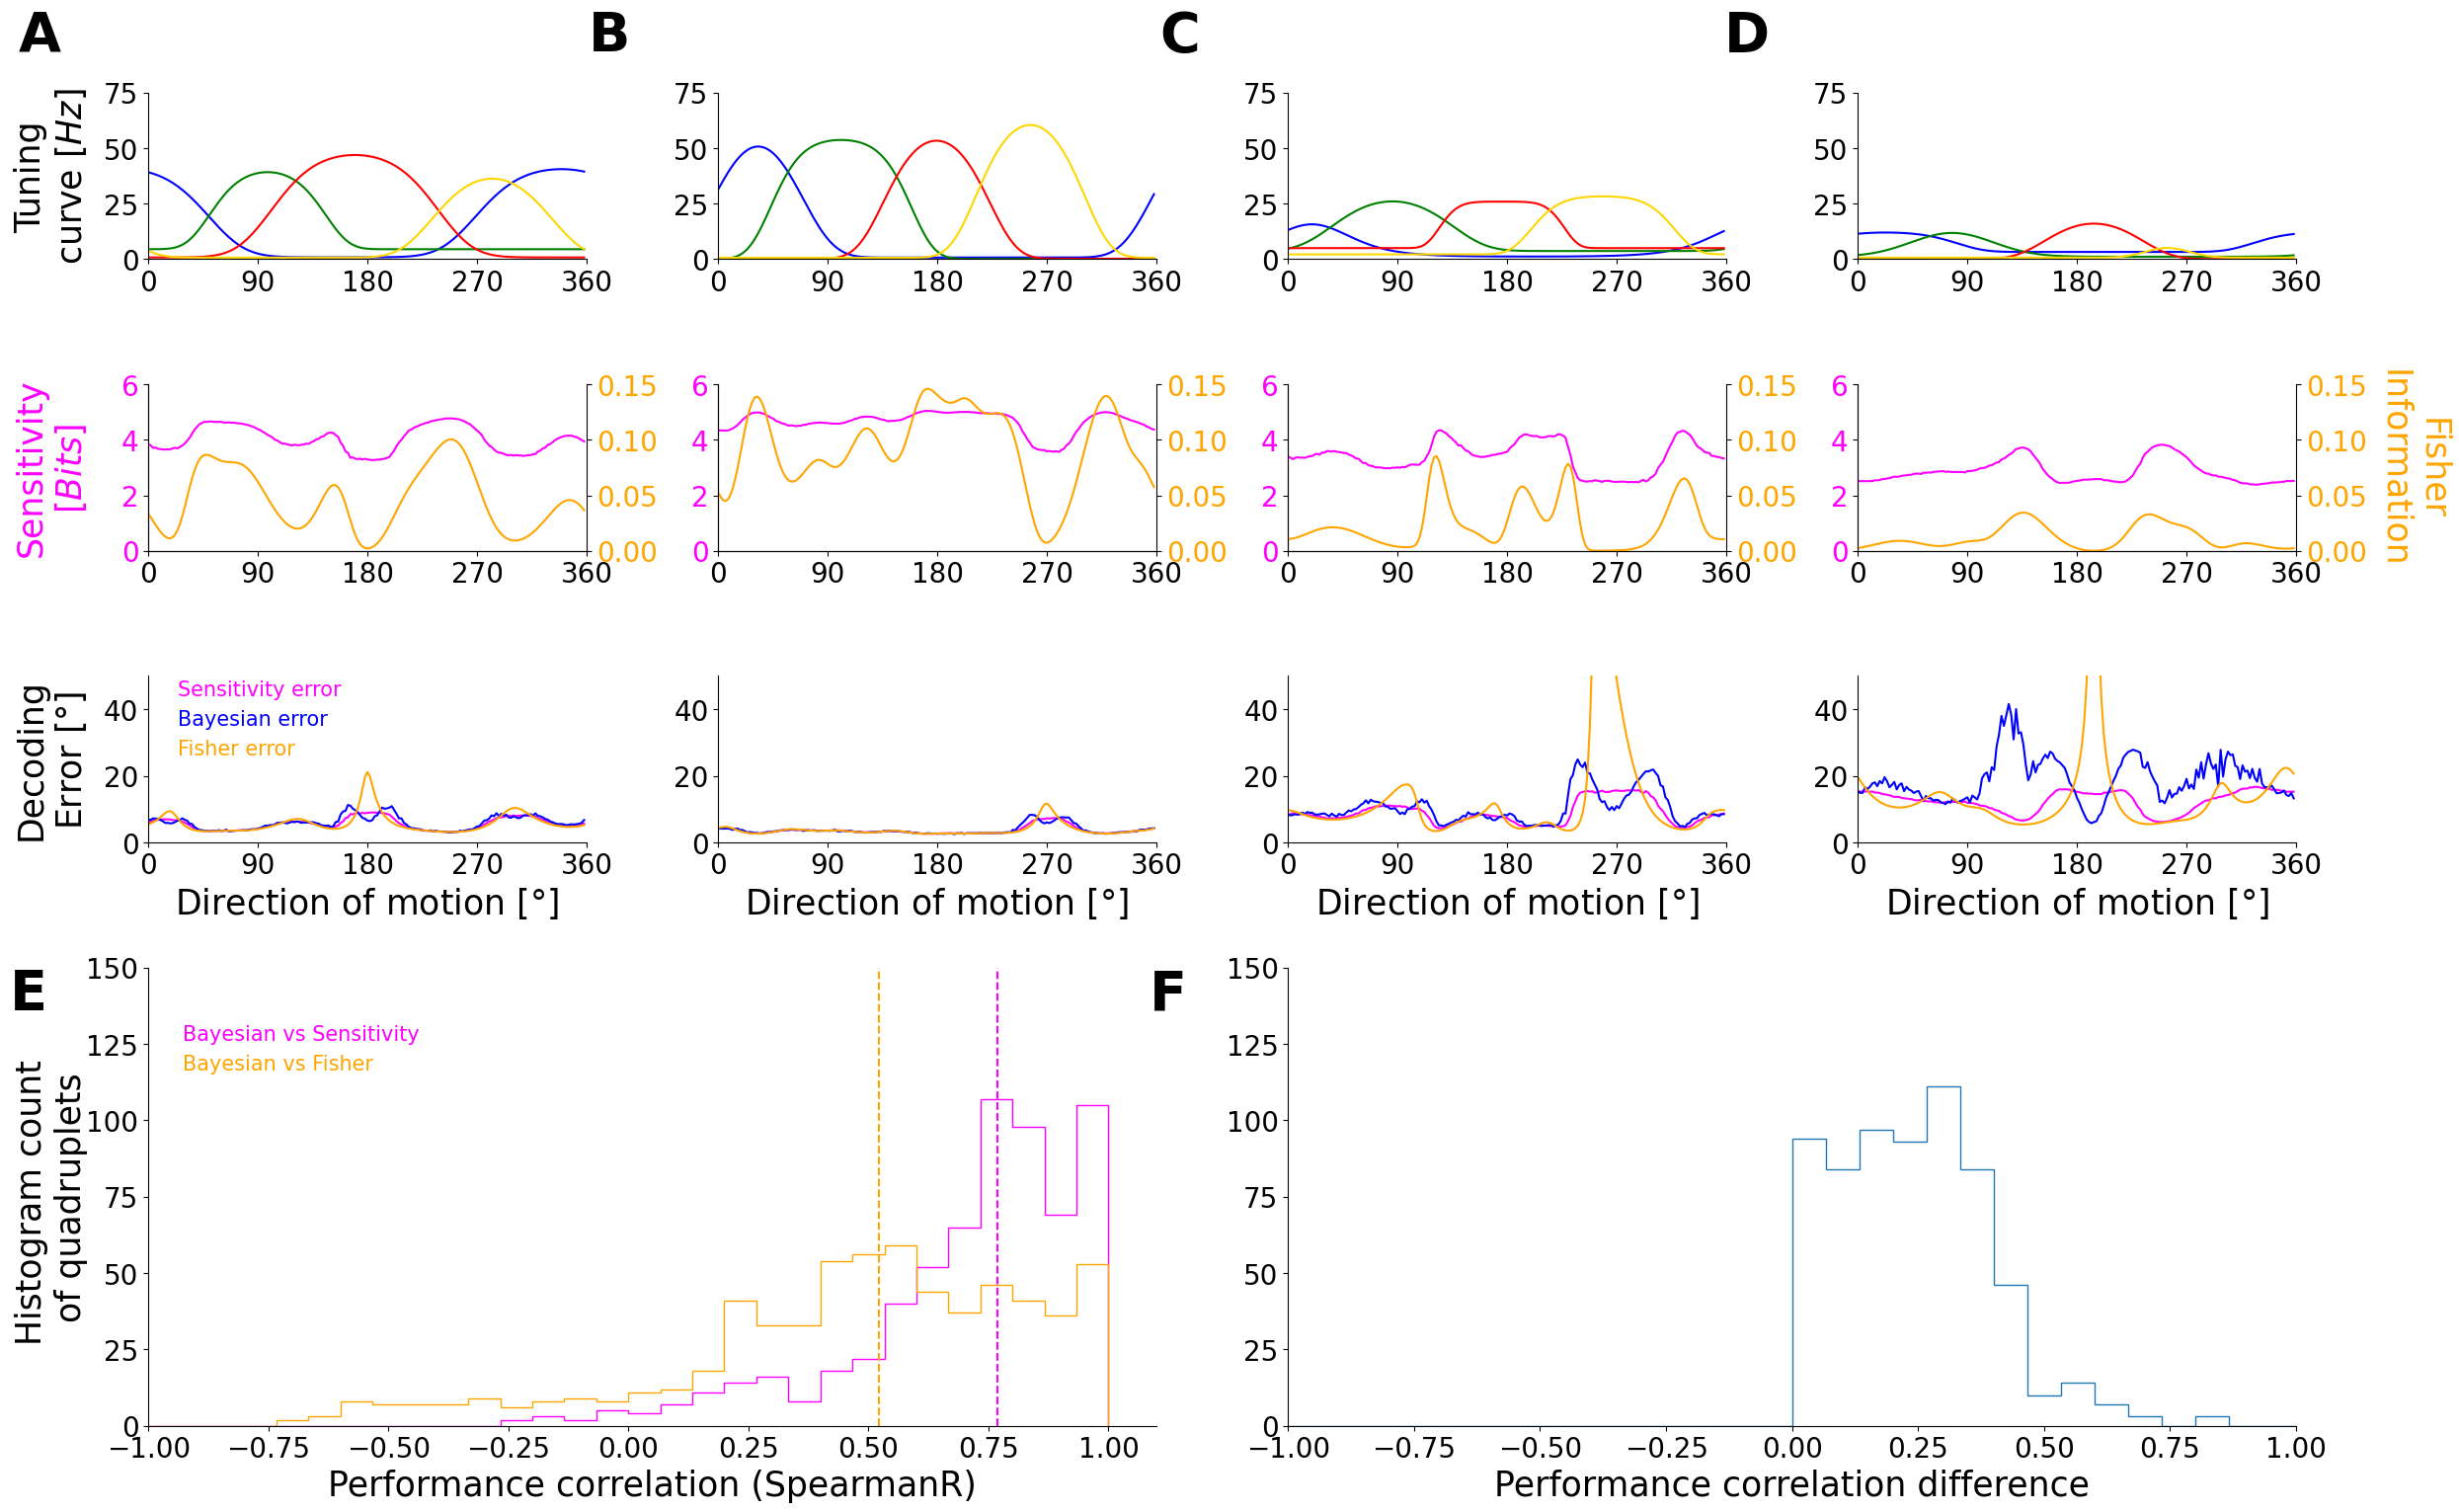

In [18]:
labelsize = 25
legend_fontsize = 15
text_size = 30
tick_labelsize = 20
letter_size=40
plt.rcParams['xtick.labelsize']=tick_labelsize
plt.rcParams['ytick.labelsize']=tick_labelsize
mpl.rcParams['axes.spines.right']=False

fig = plt.figure(figsize=(25,15))

gs = GS(5,4,wspace=0.3, hspace=0.75)
colors = ['blue', 'green', 'red', 'gold']
letters = ['A', 'B', 'C', 'D']

for i, quad in enumerate(chosen_quads):
    print(quad)
    
#     TUNING CURVE ROW
    ax = fig.add_subplot(gs[0,i])
    for j, tc in enumerate(data_dict['all_quad_tc'][quad, bio_idx]):
        ax.plot(stim, tc/1.6, color = colors[j])

    # add panel letter
    ax.text(-0.2, 1.5, letters[i], transform=ax.transAxes,
                fontsize=letter_size, fontweight='bold', va='top', ha='right')

    # aesthetics
    ax.set_xlim(0,360)
    ax.set_ylim(0,75)    
    ax.set_xticks(np.arange(0,361, 90))
    ax.set_yticks(np.arange(0,76, 25))

#     SSI ROW
        
    ax1 = fig.add_subplot(gs[1,i])
    ax2 = ax1.twinx()
    
    ax1.plot(stim, ssis[quad], color = 'magenta')
    ax2.plot(stim, fisher_info[quad], color = 'orange')
    ax2.spines['right'].set_visible(True)
    ax1.tick_params('y', labelcolor = 'magenta')
    ax2.tick_params('y', labelcolor = 'orange')
    
    ax1.set_xlim(0,360)
    ax1.set_ylim(0,6)  
    ax2.set_ylim(0,0.15)
    ax1.set_xticks(np.arange(0,361, 90))
    ax1.set_yticks(np.arange(0,6.1, 2))
    ax2.set_yticks(np.arange(0,0.151, 0.05))   
    
    ax3 = fig.add_subplot(gs[2,i])
    ax3.plot(stim, constant*math.e**(-ssis[quad]*np.log(2)), \
            color = 'magenta', label = r'Sensitivity error')
    ax3.plot(stim, bayes_dec_err[quad], color = 'blue', label = 'Bayesian error')
    ax3.plot(stim, 1/np.sqrt(fisher_info[quad]), color = 'orange', label = r'Fisher error')
    if i==0:
        ax3.legend(handlelength = 0, labelcolor = 'linecolor', frameon=0, \
                   loc = (0.01, 0.45), fontsize = legend_fontsize)
    
    ax3.set_xlim(0,360)
    ax3.set_ylim(0,50)    
    ax3.set_xticks(np.arange(0,361, 90))
    ax3.set_xlabel(r'Direction of motion [$\degree$]', size = labelsize)
    
    
    if i==0:
        ax.yaxis.set_label_coords(-0.135, y=0.5)
        ax1.yaxis.set_label_coords(-0.135, y=0.5)
        ax3.yaxis.set_label_coords(-0.135, y=0.5)
        
        ax.set_ylabel('Tuning\n'+r'curve [$Hz$]', size = labelsize)  
        ax1.set_ylabel('Sensitivity\n'+r'[$Bits$]', color = 'magenta', size = labelsize)
        ax3.set_ylabel('Decoding\n'+r'Error [$\degree$]', size = labelsize)  
    if i==len(chosen_quads)-1:
        ax2.yaxis.set_label_coords(1.35, y=0.5)
        ax2.set_ylabel('Fisher\n'+r'Information', rotation=270, color = 'orange', size = labelsize)
        


# plot performance correlation -----------------------------------------------------------        
ax4 = fig.add_subplot(gs[3:5,:2])

spearman_ssi_v_bayes = np.array([spearmanr(-data_dict['all_ssis'][idx, bio_idx], el).correlation \
                                           for idx, el in enumerate(bayes_dec_err)])
spearman_fisher_v_bayes = np.array([spearmanr(1/np.sqrt(fisher_info[idx]), el).correlation \
                                           for idx, el in enumerate(bayes_dec_err)])

ax4.hist(spearman_ssi_v_bayes, range=(-1,1), bins = 30, color = 'magenta', histtype = 'step')
ax4.plot([0],[0], color = 'magenta', label = r'Bayesian vs Sensitivity')

ax4.hist(spearman_fisher_v_bayes, range=(-1,1), bins = 30, color = 'orange', histtype = 'step')
ax4.plot([0],[0], color = 'orange',label = r'Bayesian vs Fisher')
ax4.yaxis.set_label_coords(-0.075, y=0.5)


ax4.axvline(np.median(spearman_ssi_v_bayes), color = 'magenta', linestyle='dashed')
ax4.axvline(np.median(spearman_fisher_v_bayes), color = 'orange', linestyle='dashed')
#     ax4.text(-0.9, 75, f'p-value<<{0.00001:.0e}', size = 12)
ax4.set_xticks(np.arange(-1,1.1,0.25))
ax4.set_yticks(np.arange(0,151,25))
print(wilcoxon(spearman_ssi_v_bayes-spearman_fisher_v_bayes))
ax4.set_xlim(left=-1)
ax4.set_ylim(0,150)
ax4.set_xlabel('Performance correlation (SpearmanR)', size=labelsize)
ax4.yaxis.set_label_coords(-0.06, y=0.5)
ax4.set_ylabel('Histogram count \nof quadruplets', size=labelsize)

ax4.legend(handlelength = 0, labelcolor = 'linecolor', frameon=0, fontsize = legend_fontsize, loc=(0.01, 0.75))
# ax4.text(-1.17, 157, 'E)', size=text_size)

# add panel letter
ax4.text(-0.1, 1, 'E', transform=ax4.transAxes,
            fontsize=letter_size, fontweight='bold', va='top', ha='right')


# plot performance correlation difference -----------------------------------------------------------        
ax5 = fig.add_subplot(gs[3:5,2:])
ax5.yaxis.set_label_coords(-0.06, y=0.5)

ax5.hist(spearman_ssi_v_bayes- spearman_fisher_v_bayes, bins = 30, range = (-1,1),\
         align ='mid', histtype='step')
ax5.set_xticks(np.arange(-1,1.1, 0.25))
ax5.set_yticks(np.arange(0,151,25))
ax5.set_xlim(-1,1)
ax5.set_ylim(0,150)
ax5.set_xlabel('Performance correlation difference', size=labelsize)
# ax5.set_ylabel('Histogram count \nof quadruplets', size=labelsize)
# ax5.text(-1.17, 157, 'F)', size=text_size)

# add panel letter
ax5.text(-0.1, 1, 'F', transform=ax5.transAxes,
            fontsize=letter_size, fontweight='bold', va='top', ha='right')


gs.update(left=0.055,right=0.925,top=0.95,bottom=0.05)#,wspace=0.3,hspace=0.5)

# save figure
plt.savefig('figures/fig2.svg', bbox_inches='tight', dpi = 400)
plt.savefig('figures/fig2.pdf', bbox_inches='tight', dpi = 400)

In [4]:
print(np.median(spearman_ssi_v_bayes), np.mean(spearman_ssi_v_bayes), spearman_ssi_v_bayes.std())
print(np.median(spearman_fisher_v_bayes), np.mean(spearman_fisher_v_bayes), spearman_fisher_v_bayes.std())

0.7681924339228577 0.7106931550623228 0.23985807753354832
0.5223751761885655 0.46935679948461545 0.37411322522563434
